## Code for performing model inference and generating diffusion model images

In [1]:
from pathlib import Path
from typing import Any, Optional, Union
from SUR_adapter import Adapter

import gradio as gr
import safetensors.torch
import torch
from diffusers import DPMSolverMultistepScheduler, StableDiffusionPipeline
from torchvision.utils import save_image


pipe = StableDiffusionPipeline.from_pretrained(
    'runwayml/stable-diffusion-v1-5',
    torch_dtype=torch.float16,
    safety_checker=None,
    feature_extractor=None,
    requires_safety_checker=False,
)

pipe = pipe.to("cuda:1")

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

adapter = Adapter().to(pipe.device)
safetensors.torch.load_model(adapter, "rohan.safetensors", strict=True)
adapter.adapter_weight = 1e-1
adapter.sd_text_size=768


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

## Vanilla Stable Diffusion

  0%|          | 0/50 [00:00<?, ?it/s]

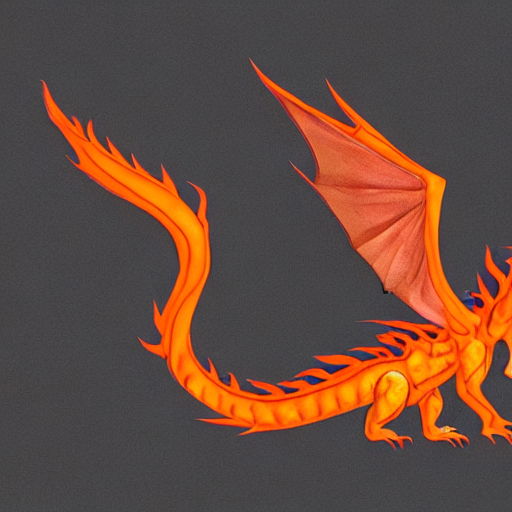

In [2]:
image = pipe(prompt='An orange dragon with a tail of fire with wings and two horns').images[0]
image

## Checking SUR-Adapter Model Inference

In [3]:
from transformers import CLIPTextModel, CLIPTokenizer

prompt = "an orange crab with a crown"

clip_tokenizer = CLIPTokenizer.from_pretrained(
    'runwayml/stable-diffusion-v1-5',
    subfolder="tokenizer",
    revision=None,
)
    
clip_text_encoder = CLIPTextModel.from_pretrained(
    'runwayml/stable-diffusion-v1-5',
    subfolder="text_encoder",
    revision=None
)

simple_tokens = clip_tokenizer(
    prompt,
    return_tensors='pt',
    max_length=clip_tokenizer.model_max_length,
    padding="max_length",
    truncation=True
)

simple_tokens.to('cuda:1')
clip_text_encoder.to('cuda:1')
simple_embed = clip_text_encoder(**simple_tokens)
clip_out_for_sur = simple_embed.last_hidden_state
out, _ , _ = adapter(clip_out_for_sur)

In [4]:
out

tensor([[[-0.2599,  0.1146, -0.7290,  ..., -1.8501, -0.9753,  0.1367],
         [ 0.1703, -2.7465,  1.6735,  ..., -1.0188,  1.8311,  1.3060],
         [ 0.5317, -0.5296,  0.9793,  ..., -1.0140, -1.1550,  2.2504],
         ...,
         [ 0.1276,  0.1634, -0.2426,  ..., -2.4832, -0.9214,  0.4941],
         [ 0.0353,  0.1522, -0.3755,  ..., -2.3090, -0.9383,  0.4026],
         [ 0.5737,  0.2333,  0.6747,  ..., -3.2604, -0.8113,  0.9686]]],
       device='cuda:1', grad_fn=<AddBackward0>)

## SUR-adapter based model Stable Diffusion

In [7]:
from pathlib import Path
from typing import Any, Optional, Union
from SUR_adapter import Adapter
from SUR_adapter_pipeline import SURStableDiffusionPipeline
import gradio as gr
import safetensors.torch
import torch
from diffusers import DPMSolverMultistepScheduler, StableDiffusionPipeline
from torchvision.utils import save_image



model_path = "runwayml/stable-diffusion-v1-5"
pipe = SURStableDiffusionPipeline.from_pretrained(model_path, adapter=adapter)
pipe = pipe.to("cuda:2")
pipe.safety_checker = lambda images,clip_input: (images, False)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

adapter = Adapter().to(pipe.device)
safetensors.torch.load_model(adapter, "rohan.safetensors", strict=True)
adapter.adapter_weight = 1e-1
adapter.sd_text_size=768

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

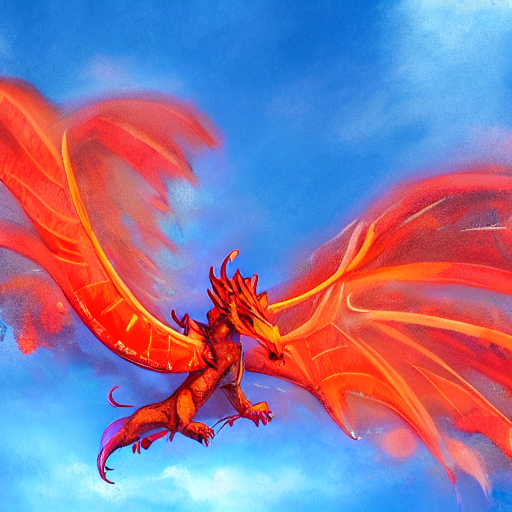

In [8]:
image = pipe(prompt='An orange dragon with a tail of fire with wings and two horns').images[0]
image